In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# source files
import sys
sys.path.append('scripts/')
from scripts.calibrated_regression import CalibratedRegression
from scripts.data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

$$
\begin{aligned}
x &\in [-10,10] \\
y &= p x^2 + \epsilon, \epsilon \sim \mathcal{N}(0,1)
\end{aligned}
$$

---

# Experiments

## Experiment 1: Polynomial Regression Model
### Misspecified Noise in the Model

$$
\begin{aligned}
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\hat{y} &\sim \mathcal{N}(ax^2 + bx + c, \sigma=1) \\
\end{aligned}
$$

Note that $\sigma=1$ but the true $\sigma$ of the data is 2. This is an example of model misspecification and cannot be avoided as we don't know what the true $\sigma$ of the data is.

### Creating Data For Experiments 1 and 2

(1250,) (250,) (1250,) (250,)


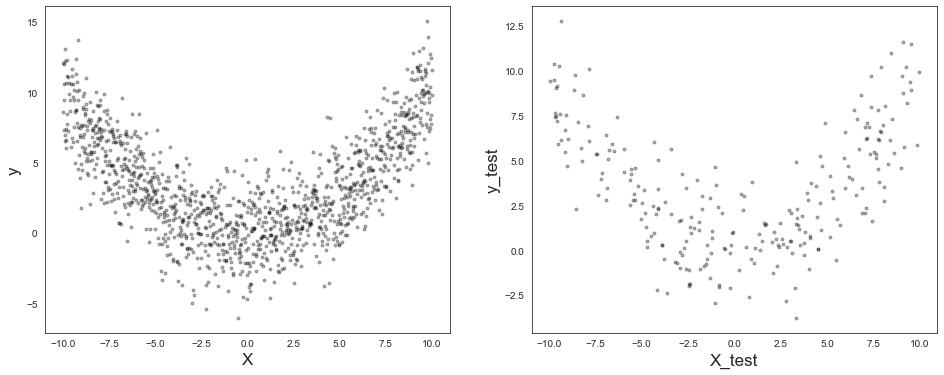

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

### Modeling

In [3]:
with pm.Model() as model_misspecified:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 638.77draws/s] 


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.101180,0.000941,0.000030,0.099404,0.103055,936.263930,1.000085
b,0.021630,0.004862,0.000126,0.012137,0.030899,1609.805907,0.999595
c,-0.034415,0.042312,0.001361,-0.121862,0.043321,941.852735,1.002123


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,2.915277,-2.385650,0.001,0.088
1,-2.328219,-0.825364,0.070,0.276
2,-5.823883,6.735119,1.000,1.000
3,9.626418,9.944859,0.674,0.584
4,-4.609740,4.167679,0.989,0.856


[0.         0.52       0.99903846]


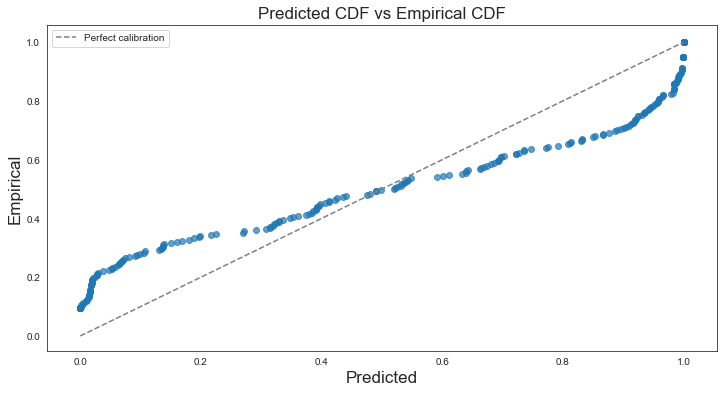

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

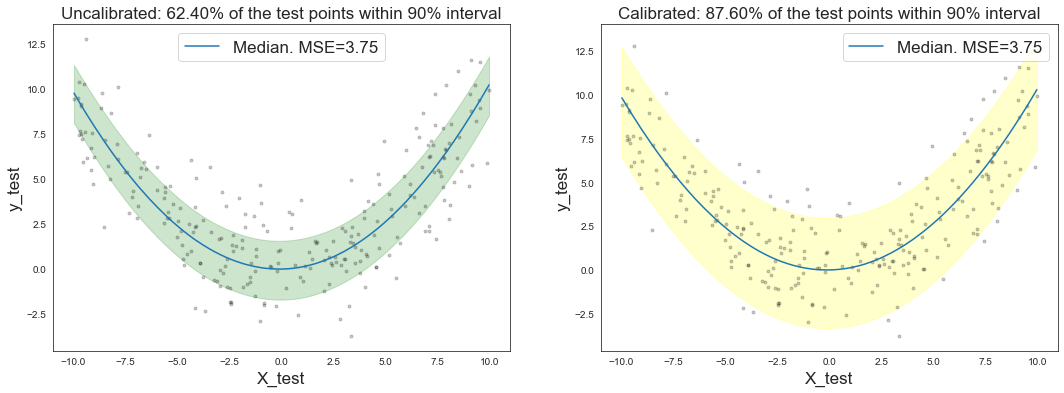

In [7]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

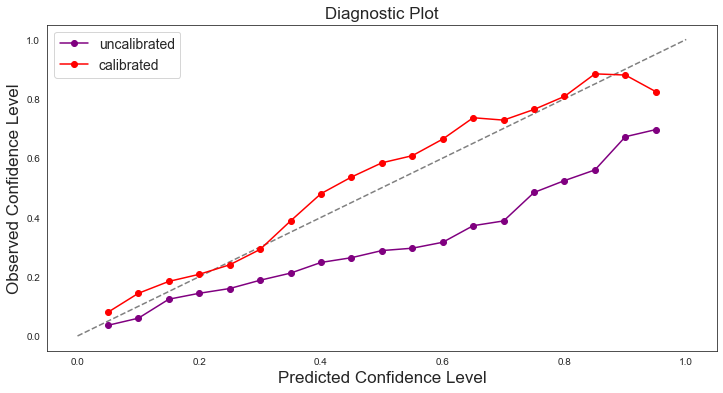

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

## Experiment 2: Polynomial Regression Model
### Misspecified Noise in the Model

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=2
$$

Note that $\sigma=2$ here, which is how the data was generated

In [9]:
with pm.Model() as model_correct:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=2, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1188.83draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.101181,0.001944,0.000063,0.097491,0.104906,965.020099,0.999667
b,0.021675,0.010000,0.000257,0.003190,0.041910,1473.128639,1.000061
c,-0.034020,0.088634,0.002873,-0.202408,0.139563,913.547355,0.999503


In [10]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':2}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,6.357572,0.511621,0.028,0.024
1,-5.903936,8.494336,0.994,0.992
2,0.847231,2.905462,0.923,0.924
3,9.853235,9.616713,0.429,0.376
4,-3.769179,-0.117837,0.246,0.228


[0.067   0.5215  0.95575]


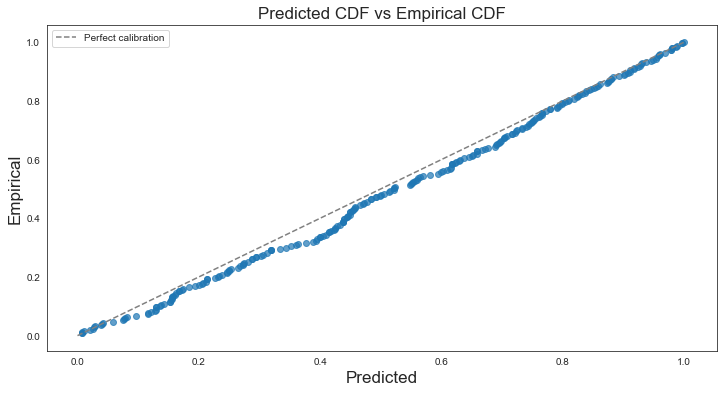

In [11]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

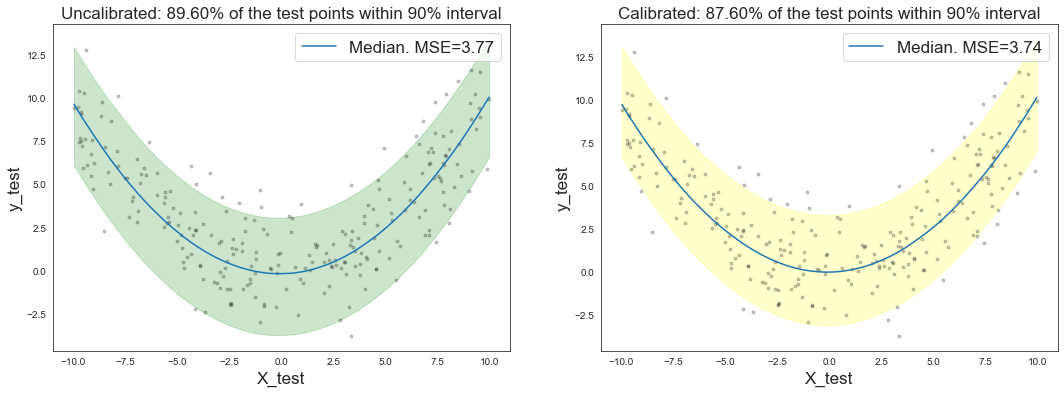

In [12]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

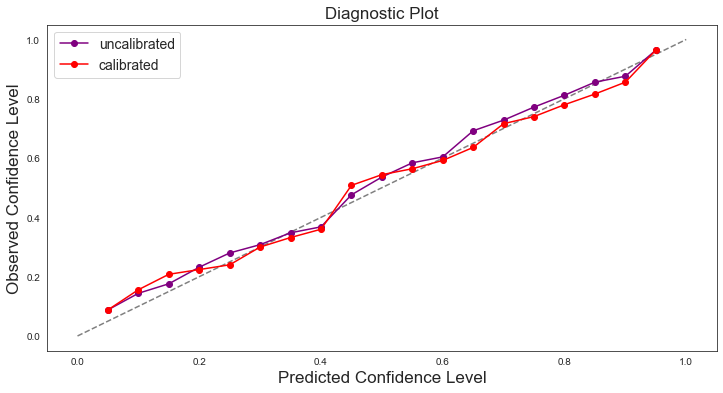

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

## Experiment 3: Polynomial Regression Model
### Dataset Shift: training data and test data are different

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

Note that $\sigma=1$ here, which is how the data was generated

### Creating Data For Experiment 3

(1250,) (250,) (1250,) (250,)


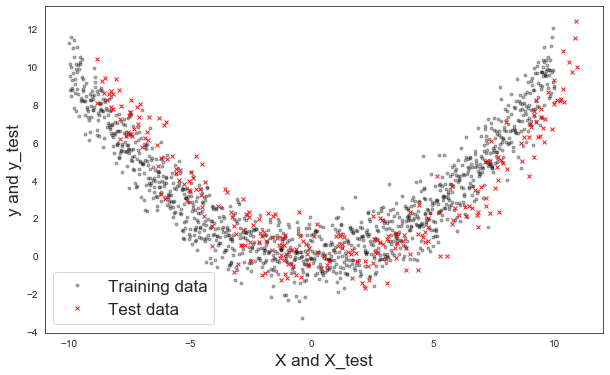

In [14]:
X, X_test, y, y_test = load_quadratic_data(scale=1)
dif = 1
X_test += dif
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.set_xlabel('X and X_test', fontsize=17)
ax.set_ylabel('y and y_test', fontsize=17)

ax.plot(X, y, 'o', markersize=3, color='black', alpha=0.3, label='Training data')
ax.plot(X_test, y_test, 'x', markersize=4, color='red', alpha=0.9, label='Test data')
ax.legend(fontsize=17)
ax.set_xlim(-11, 11+dif);

### Modeling

In [15]:
with pm.Model() as model_correct:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 840.39draws/s] 


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.100184,0.000940,0.000028,0.098265,0.101926,1224.013877,1.001872
b,0.004344,0.004949,0.000122,-0.005550,0.013760,1784.213705,0.999602
c,-0.007684,0.042559,0.001301,-0.084521,0.079532,1187.888692,1.002057


In [16]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':1}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,7.878586,6.162258,0.475,0.488
1,7.331554,4.890753,0.327,0.284
2,5.463642,2.529905,0.347,0.320
3,2.595063,-0.974177,0.061,0.072
4,0.967312,1.411285,0.894,0.936


[0.031  0.467  0.9215]


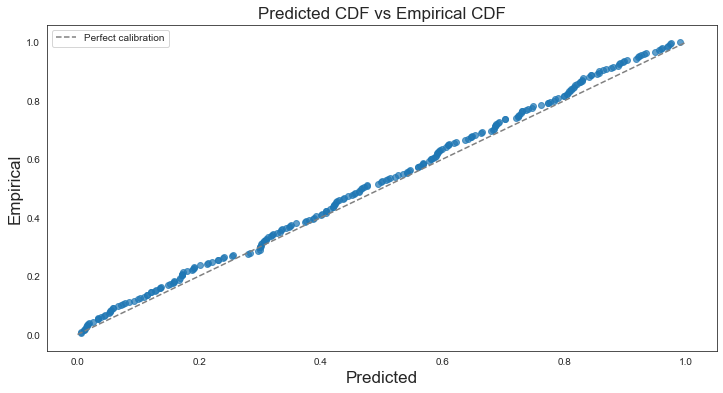

In [17]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

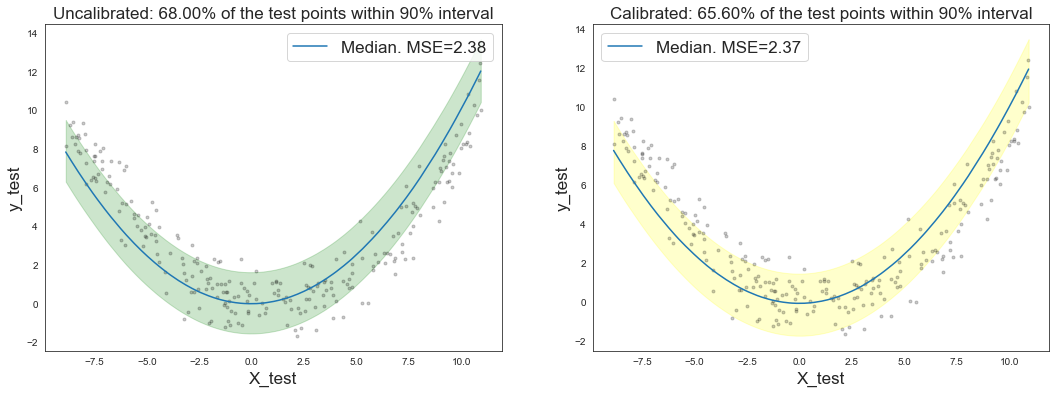

In [18]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

---